In [1]:
import torch
from torch import nn
import torchvision
import cv2
import matplotlib.pyplot as plt

In [2]:
def get_frame_index(cap, index):
    cap.set(cv2.CAP_PROP_POS_FRAMES, index)
    _, image = cap.read()
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [3]:
cap = cv2.VideoCapture('redbull480.mp4')

im1 = get_frame_index(cap, 100)
im2 = get_frame_index(cap, 110)

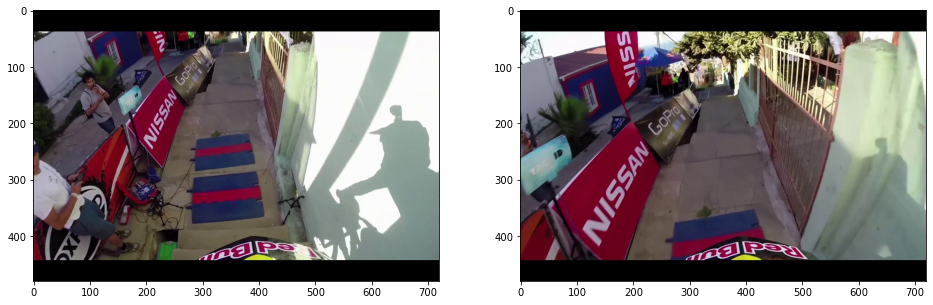

In [4]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
ax1.imshow(im1)
ax2.imshow(im2)

In [7]:
class LossNetwork(nn.Module):
    
    def __init__(self, layers):
        super(LossNetwork, self).__init__()
        
        # reconstruct pretrained VGG
        vgg = torchvision.models.vgg16_bn(pretrained=True)
        
        # delete unnecessary layers
        del vgg.avgpool
        del vgg.classifier
        
        last_layer = max(layers)
        vgg.features = vgg.features[:last_layer+1]
        
       
        
        self.model = nn.Sequential(
            *list(vgg.features.children())
        )
        
        for layer in layers:
            self.model[layer].register_forward_hook(self.hook)
            
        torch.cuda.memory.memory_cached()
        
            
    def hook(self, module, input, output):
        self.outputs.append(output)
    
    def forward(self, x):
        '''
        Returns the activation for each of specified layer index in layers
        '''
        
        self.outputs = []
        _ = self.model(x)
        
        return self.outputs
    

class PerceptualLoss(nn.Module):
    
    def __init__(self, loss_network):
        super(PerceptualLoss, self).__init__()
    
    
    def forward(self, y_hat, y):
        feat_pred = self.LossNetwork(y_hat)
        feat_true = self.LossNetwork(y)
        t_loss = 0

        for feat_pred_layer, feat_true_layer in zip(feat_pred, feat_true):
            t_loss += (feat_pred_layer-feat_true_layer).pow(2).mean()
        
        return t_loss
    
    
    
        
        
        

In [28]:
m = LossNetwork(layers=[9,16])

In [36]:
next(m.parameters())[0]

tensor([[[ 0.0828,  0.0280,  0.0771],
         [ 0.0493, -0.0334,  0.0196],
         [ 0.0803,  0.0771,  0.0833]],

        [[-0.0443, -0.1775, -0.0487],
         [-0.1100, -0.2753, -0.1347],
         [-0.0060, -0.0614,  0.0168]],

        [[ 0.0275, -0.0668,  0.0440],
         [-0.0267, -0.1500, -0.0336],
         [ 0.0528,  0.0171,  0.0867]]], grad_fn=<SelectBackward>)

In [22]:
critereon = PerceptualLoss(layers=[9,16])
critereon = critereon.eval().cuda()

In [23]:
inp1 = torch.from_numpy(im1).permute(2,0,1).unsqueeze(0)
inp2 = torch.from_numpy(im2).permute(2,0,1).unsqueeze(0)

inp1 = inp1.cuda().float()
inp2 = inp2.cuda().float()

In [24]:
loss = critereon(inp1, inp2)

In [26]:
loss

tensor(89.2628, device='cuda:0', grad_fn=<AddBackward0>)

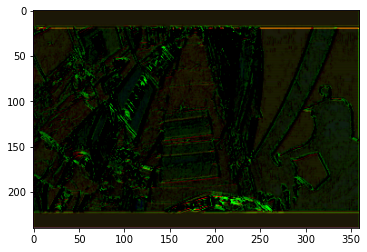

In [94]:
plt.imshow(ploss[0][0,40:43,:].permute(1,2,0).detach().cpu().clamp(0,1))

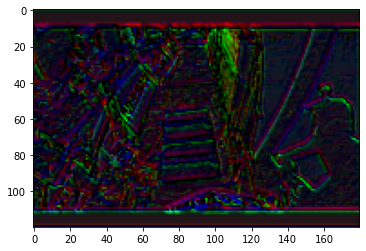

In [96]:
plt.imshow(ploss[1][0,:3,:].permute(1,2,0).detach().cpu().clamp(0,1))

In [93]:
ploss[0][0,40:43,:].permute(1,2,0).detach().cpu()

tensor(1.4021)

In [29]:
t_loss = 0
for loss1, loss2 in zip(ploss1, ploss2):
    t_loss += (loss1-loss2).pow(2).mean()

In [30]:
(feat_pred-feat_true).pow(2).mean() for feat_pred, feat_true in zip(out1, out2)]

tensor(0.0332, device='cuda:0', grad_fn=<AddBackward0>)